# Genshin Impact Reviews Analysis
## 2. Topic Modeling (Part 2) - Final Models
After having determined the optimal number of topics per model in the previous notebook. Now I will train the models again and perform EDA on the results of the modeling. I will also save the models for prediction use.

# Import Libraries and Datasets

In [1]:
import sys
import numpy as np
import pandas as pd
import math


import gensim, spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(["game", "just", "play", "would", "could"])

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Import Dataset
df = pd.read_pickle('data/final_df.p')

In [3]:
df.head()

,content,score,date,thumbsUp,source,text,length,update
0,"The graphics are gorgeous, the gameplay is inc...",5,2020-12-11 13:55:29,881.0,google_play_store,"[the, graphics, are, gorgeous, the, gameplay, ...",84,1.1.2
1,"If you love free world RPG, then this is it! T...",5,2020-12-16 18:10:47,48.0,google_play_store,"[if, you, love, free, world, rpg, then, this, ...",94,1.1.2
2,I absolutely love the game! No complaints besi...,5,2020-12-16 00:18:43,185.0,google_play_store,"[i, absolutely, love, the, game, no, complaint...",75,1.1.2
3,Great game. Regardless of ripoff issues and su...,4,2020-12-16 12:46:11,1.0,google_play_store,"[great, game, regardless, of, ripoff, issues, ...",88,1.1.2
4,Amazing graphics and gameplay although a lot o...,5,2020-12-10 22:51:08,186.0,google_play_store,"[amazing, graphics, and, gameplay, although, a...",86,1.1.2


In [4]:
df['pos_neg'] = df['score'].apply(lambda x: 'pos' if x > 3 else 'neg')

# Defining Functions

In [5]:
# tweet tokenizer
def get_sent_post(sentence):
    word_tag = nltk.pos_tag(sentence)

    new_word_tag = []

    for word, tag in word_tag:
        new_tag = tag[0]
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        new_word_tag.append((word, tag_dict.get(new_tag, wordnet.NOUN)))
    
    return new_word_tag

def process_words(data, stop_words_list = stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    
    tokenizer = TweetTokenizer()
    texts = [tokenizer.tokenize(doc) for doc in data]
    
    # build the bigram and trigram models by automatically detecting common phrases / multiword expressions
    # min_count ignores all words and bigrams with total count less than the number
    # threshold affects the number of phrases that will be created (higher threshold = fewer phrases)
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)

    # a phrases object is for learning bigrams (and multiword expressions), not for processing
    # for processing, need to use a phraser object
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # removes stopwords, lowercases, tokenizes, de-accents and 
    # removes words that are too short or too long in the text if word not in stop_words
    texts = [[word for word in simple_preprocess(str(doc), deacc=True) if word not in stop_words_list] for doc in texts]
 
    # combines bi-gram phrases
    texts = [bigram_mod[doc] for doc in texts]
    
    # combines tri-gram phrases
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # loads the spacy 'en_core_web_sm' model to get the type of pos tags for each word
    # disabling 'parser' and 'ner' for faster processing (keeping only tagger component)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    for sent in texts:
        
        # join the words together and process the it using the nlp model
        doc = nlp(" ".join(sent)) 
        
        # only keep the word if it is in the allowed pos tags
        texts_out.append([token for token in doc if token.pos_ in allowed_postags])
    

    # using NLTK's lemmatizer as it returns words into their base forms
    # it performs better than many other lemmatizer (and stemmers) as it takes into account the part-of-speech of the word
    texts_out = [[word for word in simple_preprocess(str(doc))] for doc in texts_out]

    lemmatizer = WordNetLemmatizer()
    texts_out = [[lemmatizer.lemmatize(word, pos) for word, pos in get_sent_post(sentence)] for sentence in texts_out]
    
    # remove stopwords again after lemmatizing
    texts_out = [[word for word in doc if word not in stop_words_list] for doc in texts_out]
        
    return texts_out

In [6]:
def run_ldamodel(n_topics, corpus, id2word):

    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=n_topics,
                                            random_state=11,
                                            chunksize=500,
                                            passes=10,
                                            iterations=100,
                                            per_word_topics=True)
    
    return model

In [7]:
def compute_coherence(ldamodel, processed_texts, id2word, coherence='c_v'):
    
    coherence_model_lda = CoherenceModel(model = ldamodel, 
                                         texts = processed_texts, 
                                         dictionary = id2word, 
                                         coherence = coherence)

    coherence_lda = coherence_model_lda.get_coherence()

    print('Coherence Score: ', round(coherence_lda, 3))

In [8]:
def plot_wordcloud(model):
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(background_color='white',
                      width=2000,
                      height=1200,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0,)

    topics = model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.title('Topic ' + str(i), fontsize=20)
            plt.gca().axis('off')
        else:
            fig.delaxes(ax) 

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [9]:
def create_topic_df(ldamodel, topic_list, corpus, data_df):
    
    # initialize output dataframe
    sent_topics_df = pd.DataFrame()
    
    # create a dict of the keywords for each topic
    topic_keyword_dict = dict()

    for i in range(len(ldamodel.print_topics())):
        wp = ldamodel.show_topic(i)
        topic_keyword_dict[i] = ", ".join([word for word, prop in wp])
    
    # create a dict of the main topic name for each topic 
    topic_dict = dict()
    
    for counter, topic in enumerate(topic_list):
        topic_dict[counter] = topic
        counter += 1

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        
        # get the list of topics in each review
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        # sort the topics in order of weightage
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_dict[topic_num], 
                                                                  round(prop_topic,4), topic_keyword_dict[topic_num]]), ignore_index=True)
            else:
                break
    
    # rename the columns
    sent_topics_df.columns = ['topic_no', 'topic', 'perc_contribution', 'keywords']

    # Add original text to the end of the output
    data_df.reset_index(inplace=True, drop=True)
    sent_topics_df = pd.concat([sent_topics_df, data_df], axis=1)
    
    return sent_topics_df

In [10]:
# define function to look through the n top representative texts
def representative_text(df, n_posts = 7):
    
    for i in range(int(df['Dominant_Topic'].max()+1)):
        
        temp_df = df[df['Dominant_Topic'] == i].copy()
        temp_df.sort_values('Perc_Contribution', ascending = False, inplace = True)
        
        print(f"Top {n_posts} texts for Topic {i+1}")
        print(f"Keywords: {temp_df['Keywords'].iloc[0]}")
        print(f"=======================================================================================")
                       
        for i, row in enumerate(temp_df['content'].iloc[:n_posts]):
            print(f"No {i+1}. {row}")
            
        print('\n\n')

In [11]:
def topic_rating_distribution(df):
    num_topics = int(df['Dominant_Topic'].max()+1)

    num_rows = math.ceil(num_topics/2)

    fig, ax = plt.subplots(num_rows, 2, figsize = (12, num_rows*4), sharey = True)

    plot = 0

    for i in range(num_topics):
        axis = ax[plot//2][plot%2]
        df[df['Dominant_Topic'] == i]['score'].value_counts().sort_index().plot(kind='bar', ax = axis)
        axis.set_title(f'Topic {i + 1}', fontsize = 15)
        axis.set_ylabel('')
        axis.set_xlabel('Review Rating')
        plot += 1

    plt.tight_layout()

# Patch 1.1.2

## Positive Reviews

In [12]:
data = df.loc[(df['update'] == '1.1.2') & (df['pos_neg'] == 'pos')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [13]:
model_112_pos = run_ldamodel(4, corpus, id2word)

compute_coherence(model_112_pos, data_ready, id2word)

Coherence Score:  0.432


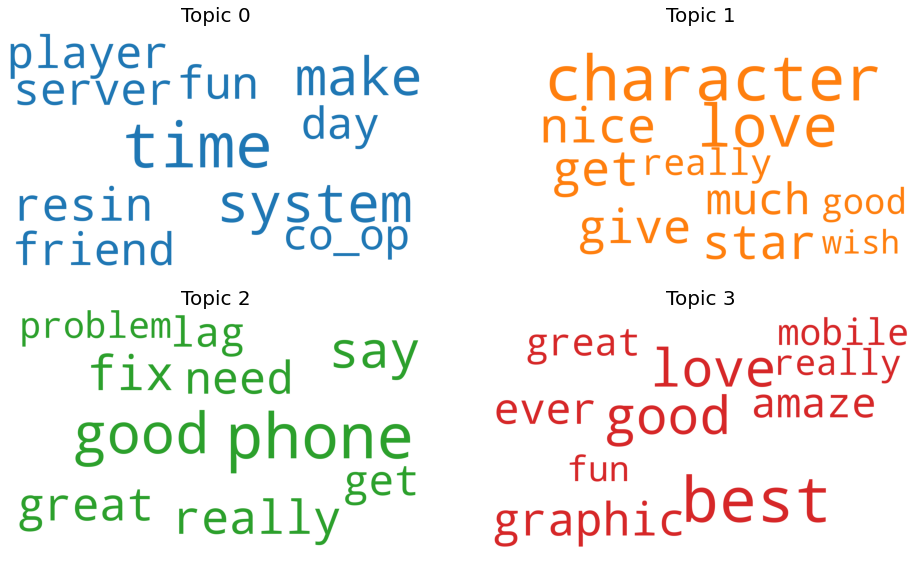

In [14]:
plot_wordcloud(model_112_pos)

**4 Topics Identified**
1. Suggestions (Resins, Coop, other improvements)
2. Characters system
3. Technical Issues (Bugs, Lags)
4. Love for the game (Graphics)

In [15]:
topics_112_pos = ['Suggestions',
                  'Character System',
                  'Technical Issues',
                  'Love for Game']

df_112_pos = create_topic_df(model_112_pos, topics_112_pos, corpus, data)

df_112_pos.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,3.0,Love for Game,0.5659,"best, love, good, graphic, ever, amaze, great,...","The graphics are gorgeous, the gameplay is inc...",5,2020-12-11 13:55:29,881.0,google_play_store,"[the, graphics, are, gorgeous, the, gameplay, ...",84,1.1.2,pos


## Negative Reviews

In [16]:
data = df.loc[(df['update'] == '1.1.2') & (df['pos_neg'] == 'neg')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [17]:
model_112_neg = run_ldamodel(3, corpus, id2word)

compute_coherence(model_112_neg, data_ready, id2word)

Coherence Score:  0.321


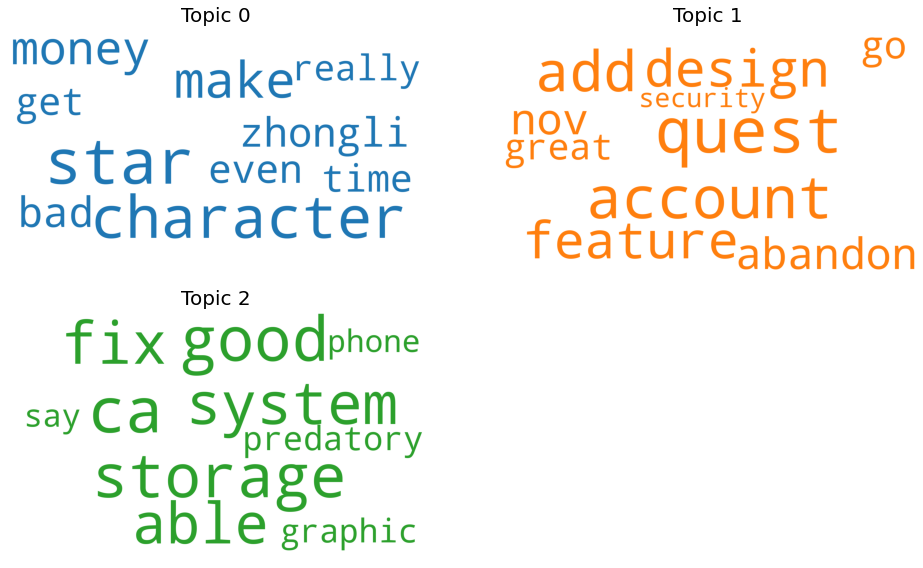

In [18]:
plot_wordcloud(model_112_neg)

**3 Topics Identified**
1. Complains on Game Systems (Special Mention of "Zhongli")
2. Account Security Issues
3. Technical Issues (Bugs, Storage)

In [19]:
topics_112_neg = ['Complaints on Game Systems',
                  'Account Security Issues',
                  'Technical Issues']

df_112_neg = create_topic_df(model_112_neg, topics_112_neg, corpus, data)

df_112_neg.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,0.0,Complaints on Game Systems,0.7621,"star, character, make, money, bad, zhongli, ev...",This game is pretty great. Until you hit late ...,3,2020-12-15 21:34:40,7.0,google_play_store,"[this, game, is, pretty, great, until, you, hi...",87,1.1.2,neg


# Patch 1.1.1

## Positive Reviews

In [20]:
data = df.loc[(df['update'] == '1.1.1') & (df['pos_neg'] == 'pos')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [21]:
model_111_pos = run_ldamodel(4, corpus, id2word)

compute_coherence(model_111_pos, data_ready, id2word)

Coherence Score:  0.463


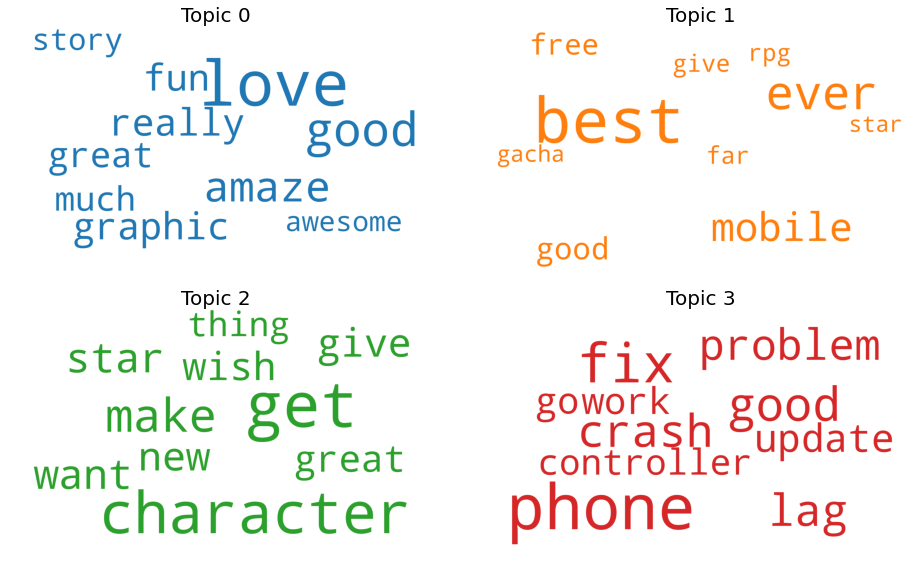

In [22]:
plot_wordcloud(model_111_pos)

**4 Topics Identified**
1. Love for the game (Graphics)
2. Love for the game (Free Mobile RPG) 
3. Topics on Characters system
4. Technical Issues (crash, bug, lags, controller)

In [23]:
topics_111_pos = ['Love for Game (Graphics)',
                  'Love for Game (Free Mobile RPG)',
                  'Character System',
                  'Technical Issues']

df_111_pos = create_topic_df(model_111_pos, topics_111_pos, corpus, data)

df_111_pos.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,1.0,Love for Game (Free Mobile RPG),0.4014,"best, ever, mobile, good, free, far, give, rpg...","One of the best, if not the best open world ga...",5,2020-12-01 07:43:24,248.0,google_play_store,"[one, of, the, best, if, not, the, best, open,...",91,1.1.1,pos


## Negative Reviews

In [24]:
data = df.loc[(df['update'] == '1.1.1') & (df['pos_neg'] == 'neg')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [25]:
model_111_neg = run_ldamodel(4, corpus, id2word)

compute_coherence(model_111_neg, data_ready, id2word)

Coherence Score:  0.461


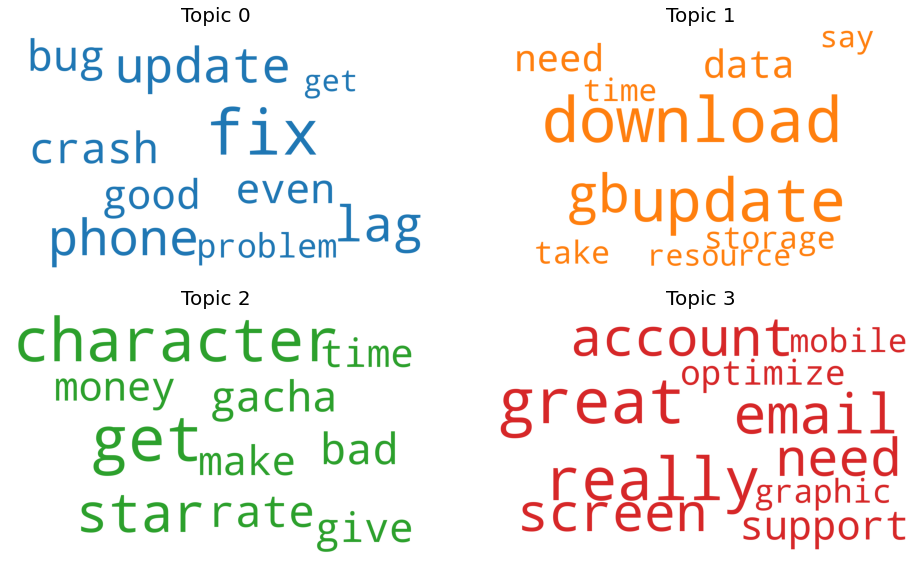

In [26]:
plot_wordcloud(model_111_neg)

**4 Topics Identified**
1. Technical issues (bugs, crash and lag)
2. Storage Issues
3. Complains on Game Systems
4. Technical Issues (mobile optimization and account security)

In [27]:
topics_111_neg = ['Technical Issues (Bugs & Lags)',
                  'Storage Issues',
                  'Complaints on Game Systems',
                  'Technical Issues (Mobile Optimization & Account Security)']

df_111_neg = create_topic_df(model_111_neg, topics_111_neg, corpus, data)

df_111_neg.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,2.0,Complaints on Game Systems,0.9159,"get, character, star, rate, bad, gacha, give, ...","Controls could be smoother, and characters cou...",3,2020-11-22 19:19:03,7.0,google_play_store,"[controls, could, be, smoother, and, character...",96,1.1.1,neg


# Patch 1.0.2

## Positive Reviews

In [28]:
data = df.loc[(df['update'] == '1.0.2') & (df['pos_neg'] == 'pos')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [29]:
model_102_pos = run_ldamodel(4, corpus, id2word)

compute_coherence(model_102_pos, data_ready, id2word)

Coherence Score:  0.538


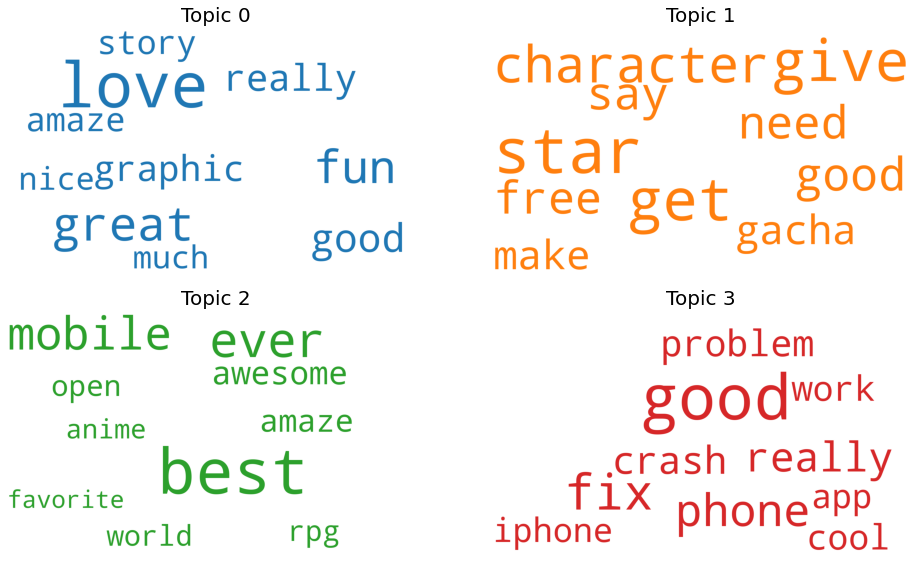

In [30]:
plot_wordcloud(model_102_pos)

**4 Topics Identified**
1. Love for the game (Graphics)
2. Characters System
3. Love for the game (Mobile RPG)
4. Technical Issues (crash, bug, lags, server ping)

In [31]:
topics_102_pos = ['Love for Game (Graphics)',
                  'Character System',
                  'Love for Game (Mobile RPG)',
                  'Technical Issues']

df_102_pos = create_topic_df(model_102_pos, topics_102_pos, corpus, data)

df_102_pos.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,1.0,Character System,0.6169,"star, get, give, character, good, say, need, f...","The game is enjoyable and interesting, but it ...",4,2020-11-08 14:22:31,0.0,google_play_store,"[the, game, is, enjoyable, and, interesting, b...",96,1.0.2,pos


## Negative Reviews

In [32]:
data = df.loc[(df['update'] == '1.0.2') & (df['pos_neg'] == 'neg')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [33]:
model_102_neg = run_ldamodel(4, corpus, id2word)

compute_coherence(model_102_neg, data_ready, id2word)

Coherence Score:  0.481


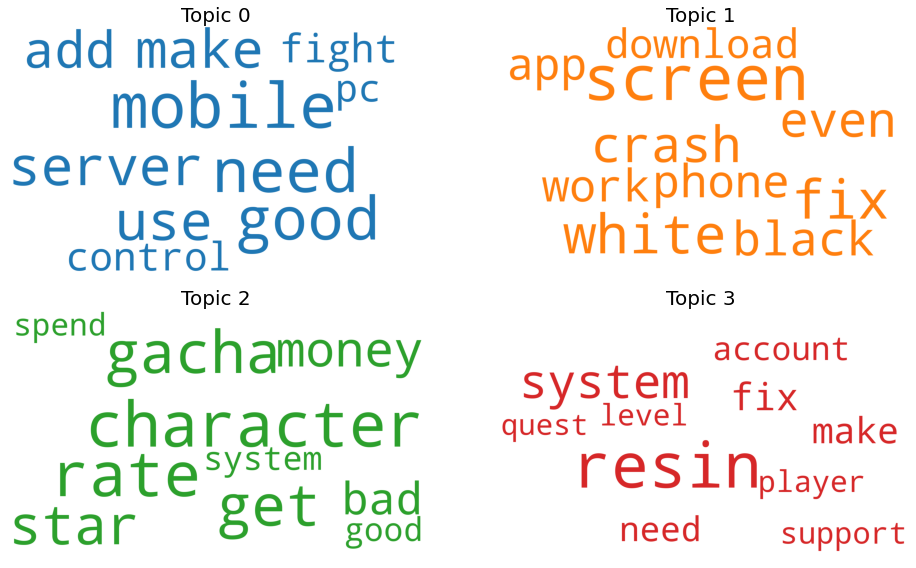

In [34]:
plot_wordcloud(model_102_neg)

**4 Topics Identified**
1. Control Issues
2. Technical Issues (Crashes)
3. Complaints on Game Systems (Character Rates)
4. Complaints on Game Systems (Resin Systems)

In [35]:
topics_102_neg = ['Control Issues',
                  'Technical Issues',
                  'Complaints on Game Systems (Character Rates)',
                  'Complaints on Game Systems (Resin Systems)']

df_102_neg = create_topic_df(model_102_neg, topics_102_neg, corpus, data)

df_102_neg.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,2.0,Complaints on Game Systems (Character Rates),0.5637,"character, rate, gacha, get, star, money, bad,...","I mean, I enjoy the game and it's very well do...",2,2020-11-06 04:29:41,2.0,google_play_store,"[i, mean, i, enjoy, the, game, and, it, s, ver...",88,1.0.2,neg


# Patch 1.0.1

## Positive Reviews

In [36]:
data = df.loc[(df['update'] == '1.0.1') & (df['pos_neg'] == 'pos')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [37]:
model_101_pos = run_ldamodel(4, corpus, id2word)

compute_coherence(model_101_pos, data_ready, id2word)

Coherence Score:  0.531


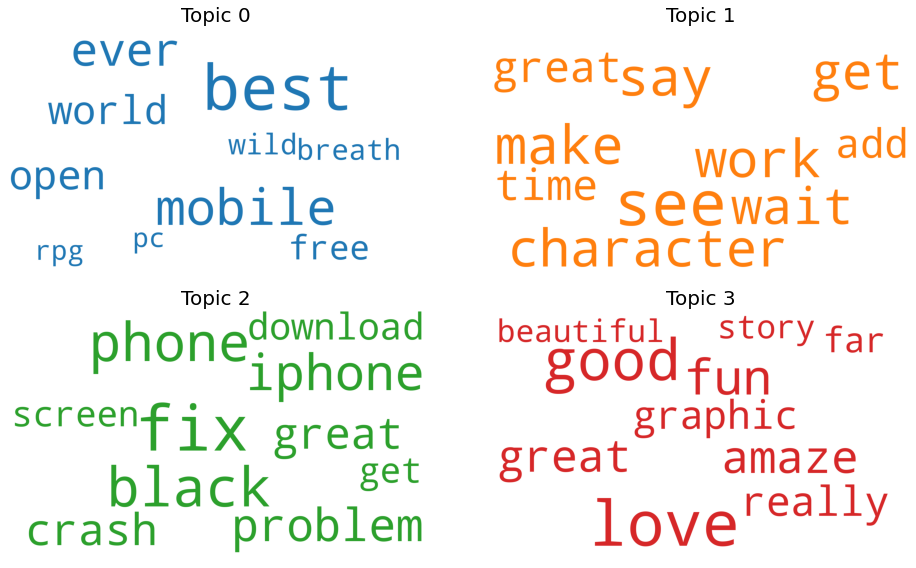

In [38]:
plot_wordcloud(model_101_pos)

**4 Topics Identified**
1. Love for Game (Free Mobile RPG)
2. Praises & Anticipation
3. Technical Issues (crash, bug, lags)
4. Love for Game (Graphics)

In [39]:
topics_101_pos = ['Love for Game (Free Mobile RPG)',
                  'Praises & Anticipation',
                  'Technical Issues',
                  'Love for Game (Graphics)']

df_101_pos = create_topic_df(model_101_pos, topics_101_pos, corpus, data)

df_101_pos.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,2.0,Technical Issues,0.8078,"fix, black, phone, iphone, problem, crash, gre...","I like this game so much, I really do. It's qu...",4,2020-10-09 23:12:07,1.0,google_play_store,"[i, like, this, game, so, much, i, really, do,...",84,1.0.1,pos


## Negative Reviews

In [40]:
data = df.loc[(df['update'] == '1.0.1') & (df['pos_neg'] == 'neg')]

data_ready = process_words(data['content'])

# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(data_ready)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

In [41]:
model_101_neg = run_ldamodel(3, corpus, id2word)

compute_coherence(model_101_neg, data_ready, id2word)

Coherence Score:  0.514


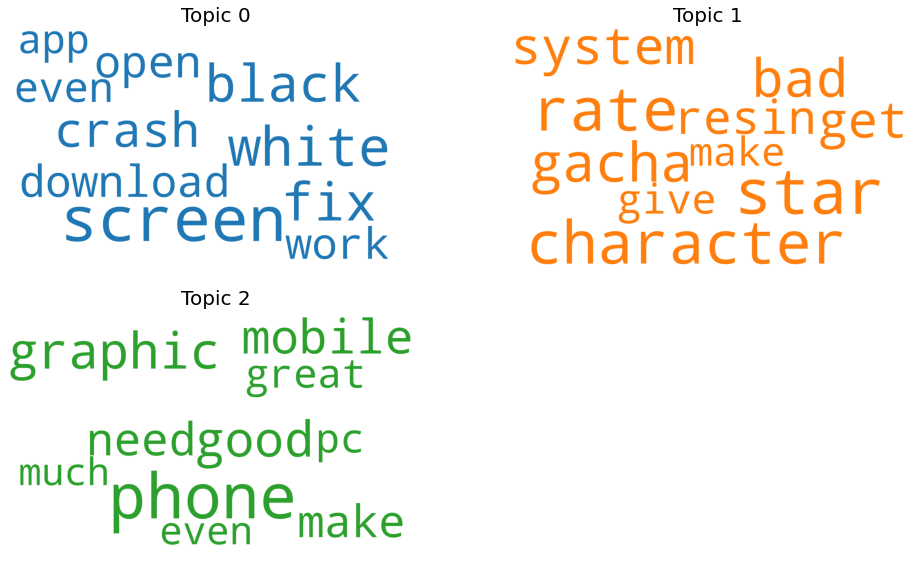

In [42]:
plot_wordcloud(model_101_neg)

**3 Topics Identified**
1. Technical Issues (Bugs, Crash and Lags)
2. Complaints on Game Systems
3. Technical Issues (Bad Mobile Performance)

In [43]:
topics_101_neg = ['Technical Issues (Bugs, Crash and Lags)',
                  'Complaints on Game Systems',
                  'Technical Issues (Bad Mobile Performance)']

df_101_neg = create_topic_df(model_101_neg, topics_101_neg, corpus, data)

df_101_neg.head(1)

,topic_no,topic,perc_contribution,keywords,content,score,date,thumbsUp,source,text,length,update,pos_neg
0,2.0,Technical Issues (Bad Mobile Performance),0.7496,"phone, graphic, good, mobile, need, make, pc, ...",I really enjoy the game and graphics of it too...,2,2020-10-12 01:52:09,3.0,google_play_store,"[i, really, enjoy, the, game, and, graphics, o...",72,1.0.1,neg


# EDA for Topic Modeling

## Define Functions

In [119]:
def create_model_stats_df(df, pos_neg):

    new_list = []

    topic_nums = range(df['topic_no'].nunique())
    total_posts = len(df)

    for topic_num in topic_nums:
        temp = df[df['topic_no'] == topic_num]

        update = temp['update'].iloc[1]
        topic = temp['topic'].iloc[1]
        keywords = temp['keywords'].iloc[1]
        n_posts = len(temp)

        if pos_neg == 'pos':
            n_posts_5 = len(temp[temp['score'] == 5])
            n_posts_4 = len(temp[temp['score'] == 4])

            new_list.append([update, topic_num, topic, keywords,
                             n_posts_4, n_posts_5, n_posts, total_posts])

            new_df = pd.DataFrame(new_list, columns=['update', 'topic_num', 'topic', 'keywords', 
                                                     'num_posts_4', 'num_posts_5', 'num_posts_total', 'num_posts_update'])

        else:
            n_posts_3 = len(temp[temp['score'] == 3])
            n_posts_2 = len(temp[temp['score'] == 2])
            n_posts_1 = len(temp[temp['score'] == 1])

            new_list.append([update, topic_num, topic, keywords,
                             n_posts_1, n_posts_2, n_posts_3, n_posts, total_posts])

            new_df = pd.DataFrame(new_list, columns=['update', 'topic_num', 'topic', 'keywords', 
                                                     'num_posts_1', 'num_posts_2', 'num_posts_3', 'num_posts_total', 'num_posts_update'])

    return new_df

In [120]:
def plot_topics_perc_change(df, pos, title, topic_list, ylim = None):
    for topic in topic_list:
        temp_df = df[df['topic'].str.contains(topic)].groupby('update', dropna = False).sum()[['num_posts_total_perc']]
        temp_df.columns = [topic]

        try: 
            new_df = pd.concat([new_df, temp_df], axis = 1)
        except:
            new_df = temp_df.copy()
        
        new_df.sort_index(inplace = True)
        new_df.fillna(0, inplace = True)
    
    plt.figure(figsize = (12, 5))
    for topic in topic_list:
        sns.lineplot(x = new_df.index, y = new_df[topic], marker = 'o', label = topic)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, fontsize = 12)
    plt.title(title, fontsize = 20)
    plt.xticks(range(4), labels = ['1.0.1', '1.0.2', '1.1.1', '1.1.2'])
    
    if ylim != None:
        plt.ylim(0, ylim)
    else: 
        plt.ylim(0)
    
    plt.xlabel('Update Number', fontsize = 15)
    if pos:
        plt.ylabel('Percentage of Positive Reviews', fontsize = 15)
    else:
        plt.ylabel('Percentage of Negative Reviews', fontsize = 15)
    plt.show()

## Overall Trend of Positive/Negative Reviews

In [76]:
df.groupby(['update', 'pos_neg']).count()[['content']]

content
update pos_neg         
1.0.1  neg         9365
       pos        41840
1.0.2  neg         4339
       pos        11499
1.1.1  neg         3461
       pos         9756
1.1.2  neg         2509
       pos         5430

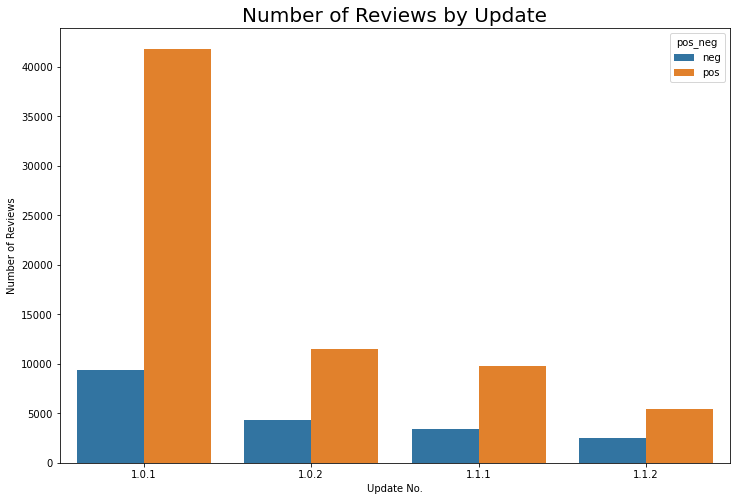

In [6]:
plt.figure(figsize = (12, 8))
temp_b = df.groupby(['update', 'pos_neg']).count()[['content']].reset_index()
sns.barplot(x = 'update', y = 'content', data = temp_b, hue = 'pos_neg')
plt.title('Number of Reviews by Update', fontsize = 20)
plt.ylabel('Number of Reviews')
plt.xlabel('Update No.')
plt.show()

**positive/negative**
- 1.0.1: 4.5 times
- 1.0.2: 2.6 times
- 1.1.1: 2.8 times
- 1.1.2: 2.2 times

## Positive Reviews

In [46]:
pos_stats_df = create_model_stats_df(df_112_pos, 'pos')
pos_stats_df = pd.concat([pos_stats_df, create_model_stats_df(df_111_pos, 'pos')])
pos_stats_df = pd.concat([pos_stats_df, create_model_stats_df(df_102_pos, 'pos')])
pos_stats_df = pd.concat([pos_stats_df, create_model_stats_df(df_101_pos, 'pos')])

pos_stats_df['num_posts_total_perc'] = pos_stats_df['num_posts_total'] / pos_stats_df['num_posts_update']
pos_stats_df.reset_index(drop = True, inplace = True)

pos_stats_df

,update,topic_num,topic,keywords,num_posts_4,num_posts_5,num_posts_total,num_posts_update,num_posts_total_perc
0,1.1.2,0,Suggestions,"time, system, make, resin, fun, player, friend...",148,434,582,5430,0.107182
1,1.1.2,1,Character System,"character, love, get, nice, star, give, much, ...",224,954,1178,5430,0.216943
2,1.1.2,2,Technical Issues,"phone, good, say, fix, really, great, need, ge...",472,827,1299,5430,0.239227
3,1.1.2,3,Love for Game,"best, love, good, graphic, ever, amaze, great,...",140,2231,2371,5430,0.436648
4,1.1.1,0,Love for Game (Graphics),"love, good, amaze, really, graphic, fun, great...",391,3485,3876,9756,0.397294
5,1.1.1,1,Love for Game (Free Mobile RPG),"best, ever, mobile, good, free, far, give, rpg...",275,1715,1990,9756,0.203977
6,1.1.1,2,Character System,"get, character, make, star, want, new, give, w...",623,1706,2329,9756,0.238725
7,1.1.1,3,Technical Issues,"phone, fix, good, crash, lag, problem, update,...",554,1007,1561,9756,0.160004
8,1.0.2,0,Love for Game (Graphics),"love, great, fun, good, really, graphic, amaze...",492,3825,4317,11499,0.375424
9,1.0.2,1,Character System,"star, get, give, character, good, say, need, f...",633,1720,2353,11499,0.204626


**Main Topics Identified Across All Updates**
1. Love for Game
2. Technical Issues
3. Character System
4. Praises and Anticipation
5. Suggestions

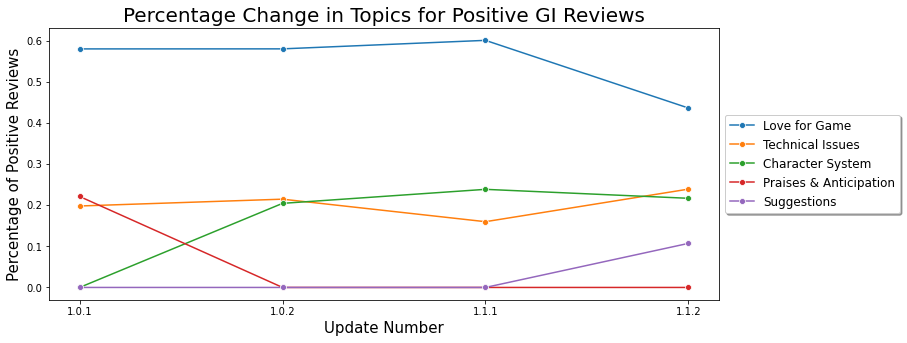

In [47]:
topic_list = ['Love for Game', 'Technical Issues', 'Character System', 'Praises & Anticipation', 'Suggestions']

plot_topics_perc_change(pos_stats_df, True, 'Percentage Change in Topics for Positive GI Reviews', topic_list)

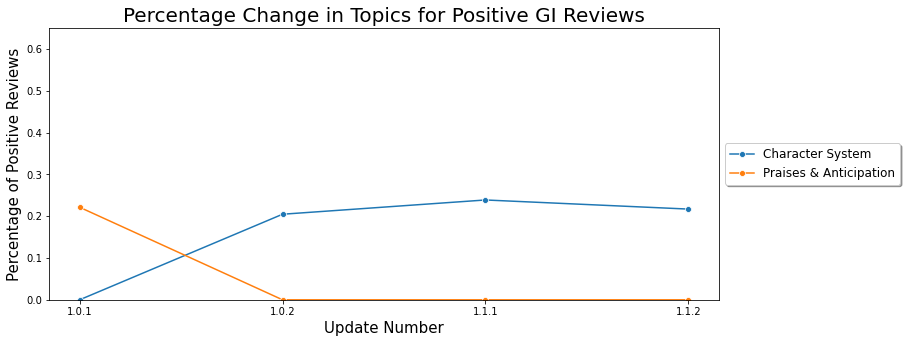

In [83]:
topic_list = ['Character System', 'Praises & Anticipation']

plot_topics_perc_change(pos_stats_df, True, 'Percentage Change in Topics for Positive GI Reviews', topic_list, ylim = 0.65)

In [49]:
pos_stats_df[pos_stats_df['topic'].str.contains("Praises & Anticipation")][['update', 'topic', 'keywords']]

,update,topic,keywords
13,1.0.1,Praises & Anticipation,"see, make, say, work, character, get, wait, gr..."


The topic only exists for 1.0.1. These reviews consist of praises and also comments from built up anticipation for this game.

In [91]:
pos_stats_df[pos_stats_df['topic'].str.contains("Character System")][['update', 'topic', 'keywords']]

,update,topic,keywords
1,1.1.2,Character System,"character, love, get, nice, star, give, much, ..."
6,1.1.1,Character System,"get, character, make, star, want, new, give, w..."
9,1.0.2,Character System,"star, get, give, character, good, say, need, f..."


General Comments on Character System - Consist of good and "bad" reviews

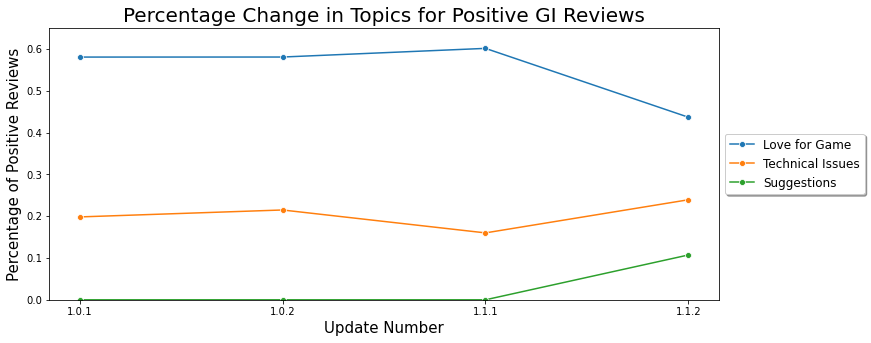

In [51]:
topic_list = ['Love for Game', 'Technical Issues', 'Suggestions']

plot_topics_perc_change(pos_stats_df, True, 'Percentage Change in Topics for Positive GI Reviews', topic_list, ylim = 0.65)

In [52]:
pos_stats_df[pos_stats_df['topic'].str.contains("Love for Game")][['update', 'topic', 'keywords']][['update', 'topic', 'keywords']]

,update,topic,keywords
3,1.1.2,Love for Game,"best, love, good, graphic, ever, amaze, great,..."
4,1.1.1,Love for Game (Graphics),"love, good, amaze, really, graphic, fun, great..."
5,1.1.1,Love for Game (Free Mobile RPG),"best, ever, mobile, good, free, far, give, rpg..."
8,1.0.2,Love for Game (Graphics),"love, great, fun, good, really, graphic, amaze..."
10,1.0.2,Love for Game (Mobile RPG),"best, ever, mobile, awesome, amaze, open, rpg,..."
12,1.0.1,Love for Game (Free Mobile RPG),"best, mobile, ever, open, world, free, breath,..."
15,1.0.1,Love for Game (Graphics),"love, good, fun, amaze, great, really, graphic..."


- Huge decreased in percentage (20%) by 1.1.2
- Large amount of comparison in 1.0.1 to Zelda Breath of the Wild

Huge decrease could be due to more incoming reviews from people who have played the game for a long time and hence, may have more issues they like to raise, instead of just saying how much they love the game.

In [84]:
pos_stats_df[pos_stats_df['topic'].str.contains("Technical Issue")][['update', 'topic', 'keywords']]

,update,topic,keywords
2,1.1.2,Technical Issues,"phone, good, say, fix, really, great, need, ge..."
7,1.1.1,Technical Issues,"phone, fix, good, crash, lag, problem, update,..."
11,1.0.2,Technical Issues,"good, fix, phone, really, crash, problem, cool..."
14,1.0.1,Technical Issues,"fix, black, phone, iphone, problem, crash, gre..."


In [54]:
pos_stats_df[pos_stats_df['topic'].str.contains("Suggestions")][['update', 'topic', 'keywords']]

,update,topic,keywords
0,1.1.2,Suggestions,"time, system, make, resin, fun, player, friend..."


- New Topic identified in 1.1.2: Suggestion for Resin System and Co-op Play

People have played most through most of the content and are requesting for new features/changes to existing features.

## Negative Reviews

In [55]:
neg_stats_df = create_model_stats_df(df_112_neg, 'neg')
neg_stats_df = pd.concat([neg_stats_df, create_model_stats_df(df_111_neg, 'neg')])
neg_stats_df = pd.concat([neg_stats_df, create_model_stats_df(df_102_neg, 'neg')])
neg_stats_df = pd.concat([neg_stats_df, create_model_stats_df(df_101_neg, 'neg')])

neg_stats_df['num_posts_total_perc'] = neg_stats_df['num_posts_total'] / neg_stats_df['num_posts_update']
neg_stats_df.reset_index(drop = True, inplace = True)

neg_stats_df

,update,topic_num,topic,keywords,num_posts_1,num_posts_2,num_posts_3,num_posts_total,num_posts_update,num_posts_total_perc
0,1.1.2,0,Complaints on Game Systems,"star, character, make, money, bad, zhongli, ev...",746,171,203,1120,2509,0.446393
1,1.1.2,1,Account Security Issues,"quest, account, add, design, feature, abandon,...",299,35,58,392,2509,0.156238
2,1.1.2,2,Technical Issues,"ca, good, storage, system, fix, able, predator...",484,163,350,997,2509,0.397369
3,1.1.1,0,Technical Issues (Bugs & Lags),"fix, phone, lag, update, crash, bug, even, goo...",408,207,373,988,3461,0.285467
4,1.1.1,1,Storage Issues,"download, update, gb, data, need, take, storag...",549,168,244,961,3461,0.277665
5,1.1.1,2,Complaints on Game Systems,"get, character, star, rate, bad, gacha, give, ...",569,181,329,1079,3461,0.311760
6,1.1.1,3,Technical Issues (Mobile Optimization & Accoun...,"great, really, email, account, screen, need, s...",228,70,135,433,3461,0.125108
7,1.0.2,0,Control Issues,"mobile, need, good, server, use, make, add, co...",244,78,202,524,4339,0.120765
8,1.0.2,1,Technical Issues,"screen, white, fix, crash, even, black, phone,...",1038,328,511,1877,4339,0.432588
9,1.0.2,2,Complaints on Game Systems (Character Rates),"character, rate, gacha, get, star, money, bad,...",583,164,242,989,4339,0.227933


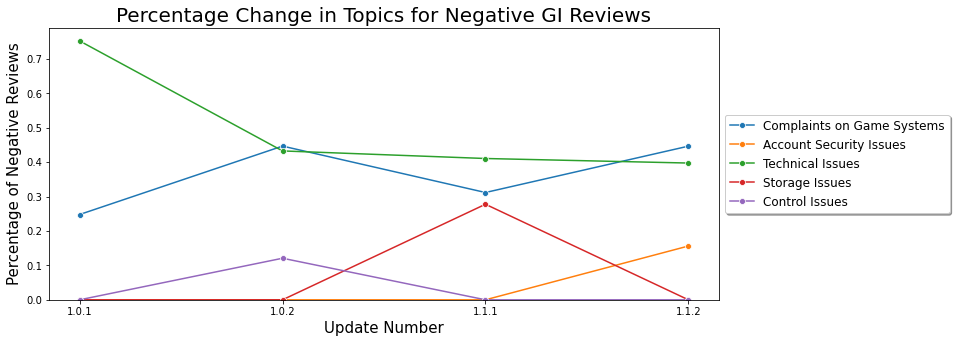

In [121]:
topic_list = ['Complaints on Game Systems', 'Account Security Issues', 'Technical Issues', 'Storage Issues', 'Control Issues']

plot_topics_perc_change(neg_stats_df, False, 'Percentage Change in Topics for Negative GI Reviews', topic_list)

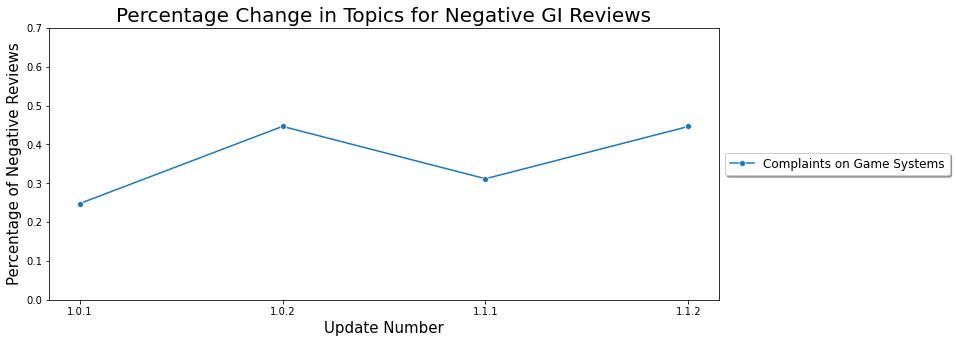

In [124]:
topic_list = ['Complaints on Game Systems']

plot_topics_perc_change(neg_stats_df, False, 'Percentage Change in Topics for Negative GI Reviews', topic_list, ylim = 0.7)

In [57]:
neg_stats_df[neg_stats_df['topic'].str.contains("Complaints on Game Systems")][['update', 'topic', 'keywords']]

,update,topic,keywords
0,1.1.2,Complaints on Game Systems,"star, character, make, money, bad, zhongli, ev..."
5,1.1.1,Complaints on Game Systems,"get, character, star, rate, bad, gacha, give, ..."
9,1.0.2,Complaints on Game Systems (Character Rates),"character, rate, gacha, get, star, money, bad,..."
10,1.0.2,Complaints on Game Systems (Resin Systems),"resin, system, fix, make, need, account, suppo..."
12,1.0.1,Complaints on Game Systems,"star, rate, character, gacha, bad, system, get..."


- Most of these complaints are on character rates and monetization of the game. (I.e. people complaining that the cost to get a good (5 stars) character is too low)
- In 1.0.2: There is an additional topic of Resin System. This was the point when most players finished the story content and needed Resins to progress in level. People obviously got used to it at the topic did not surface again.
- In 1.1.2: The word "Zhongli" appeared. This is a 5 stars character which was perceived as too weak by the community, resulting in huge backlash. The game will be improving this character in the next patch.

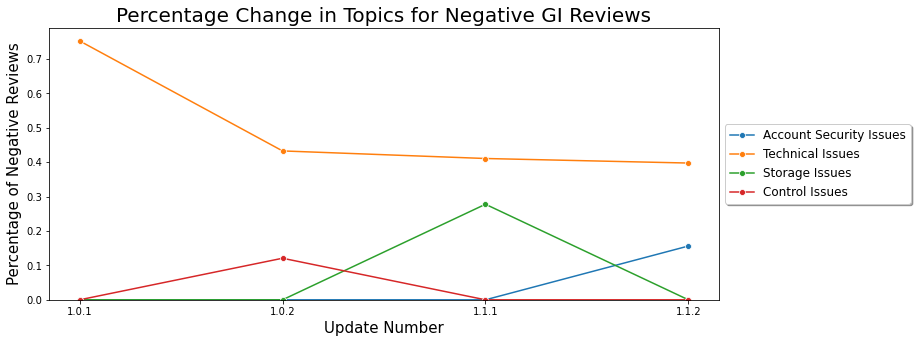

In [125]:
topic_list = ['Account Security Issues', 'Technical Issues', 'Storage Issues', 'Control Issues']

plot_topics_perc_change(neg_stats_df, False, 'Percentage Change in Topics for Negative GI Reviews', topic_list)

In [58]:
neg_stats_df[neg_stats_df['topic'].str.contains("Technical Issues")][['update', 'topic', 'keywords']]

,update,topic,keywords
2,1.1.2,Technical Issues,"ca, good, storage, system, fix, able, predator..."
3,1.1.1,Technical Issues (Bugs & Lags),"fix, phone, lag, update, crash, bug, even, goo..."
6,1.1.1,Technical Issues (Mobile Optimization & Accoun...,"great, really, email, account, screen, need, s..."
8,1.0.2,Technical Issues,"screen, white, fix, crash, even, black, phone,..."
11,1.0.1,"Technical Issues (Bugs, Crash and Lags)","screen, white, fix, black, crash, open, downlo..."
13,1.0.1,Technical Issues (Bad Mobile Performance),"phone, graphic, good, mobile, need, make, pc, ..."


- In 1.0.1 & 1.0.2: Focus of technical issues was on black/white screen crashes
- In 1.1.1: Focus on bugs, lags and some mentioned of account security issues

In [61]:
neg_stats_df[neg_stats_df['topic'].str.contains('Control Issues')][['update', 'topic', 'keywords']]

,update,topic,keywords
7,1.0.2,Control Issues,"mobile, need, good, server, use, make, add, co..."


- Mention of Control Issues (hard to control camera on mobile and requesting for controller supports)

Controller support will be added in the next patch.

In [60]:
neg_stats_df[neg_stats_df['topic'].str.contains('Storage Issues')][['update', 'topic', 'keywords']]

,update,topic,keywords
4,1.1.1,Storage Issues,"download, update, gb, data, need, take, storag..."


- A lot of storage size issue after first major update

In [59]:
neg_stats_df[neg_stats_df['topic'].str.contains("Account Security Issues")][['update', 'topic', 'keywords']]

,update,topic,keywords
1,1.1.2,Account Security Issues,"quest, account, add, design, feature, abandon,..."


- In 1.1.2: Huge increase in reviews on account security issues, probably because their accounts has been hacked.

# Saving all the models

In [ ]:
model_112_pos.save('models/112_pos.model')
model_112_neg.save('models/112_neg.model')

model_111_pos.save('models/111_pos.model')
model_111_neg.save('models/111_neg.model')

model_102_pos.save('models/102_pos.model')
model_102_neg.save('models/102_neg.model')

model_101_pos.save('models/101_pos.model')
model_101_neg.save('models/101_neg.model')